In [1]:
import pandas as pd
import numpy as np
from kbgen.config import rootdir
import urllib.request
import os


def delta(Z, N):
    A = Z + N
    aP = 11.18
    delta = aP * A ** (-1 / 2)
    delta[(Z % 2 == 1) & (N % 2 == 1)] *= -1
    delta[(Z % 2 == 0) & (N % 2 == 1)] = 0
    delta[(Z % 2 == 1) & (N % 2 == 0)] = 0
    return delta


def semi_empirical_mass_formula(Z, N):
    A = N + Z
    aV = 15.75
    aS = 17.8
    aC = 0.711
    aA = 23.7
    Eb = (
        aV * A
        - aS * A ** (2 / 3)
        - aC * Z * (Z - 1) / (A ** (1 / 3))
        - aA * (N - Z) ** 2 / A
        + delta(Z, N)
    )
    Eb[Eb < 0] = 0
    return Eb / A * 1000  # keV


def apply_to_df_col(column):
    def wrapper(fn):
        return lambda df: df[column].astype(str).apply(fn)

    return wrapper


@apply_to_df_col(column="jp")
def get_spin_from(string):
    string = (
        string.replace("(", "")
        .replace(")", "")
        .replace("+", "")
        .replace("-", "")
        .replace("]", "")
        .replace("[", "")
        .replace("GE", "")
        .replace("HIGH J", "")
        .replace(">", "")
        .replace("<", "")
        .strip()
        .split(" ")[0]
    )
    if string == "":
        return float("nan")
    else:
        return float(eval(string))  # eval for 1/2 and such


@apply_to_df_col("jp")
def get_parity_from(string):
    # find the first + or -
    found_plus = string.find("+")
    found_minus = string.find("-")

    if found_plus == -1 and found_minus == -1:
        return float("nan")
    elif found_plus == -1:
        return 0  # -
    elif found_minus == -1:
        return 1  # +
    elif found_plus < found_minus:
        return 1  # +
    elif found_plus > found_minus:
        return 0  # -
    else:
        raise ValueError("something went wrong")


def get_half_life_from(df):
    # selection excludes unknown lifetimes and ones where lifetimes are given as bounds
    series = df.half_life_sec.copy()
    series[(df.half_life_sec == " ") | (df.operator_hl != " ")] = float("nan")
    series = series.astype(float)
    series = series.apply(np.log10)
    return series


@apply_to_df_col("qa")
def get_qa_from(string):
    # ~df.qa.isna() & (df.qa != " ")
    if string == " ":
        return float("nan")
    else:
        return float(string)


@apply_to_df_col("qbm")
def get_qbm_from(string):
    return float(string.replace(" ", "nan"))


@apply_to_df_col("qbm_n")
def get_qbm_n_from(string):
    return float(string.replace(" ", "nan"))


@apply_to_df_col("qec")
def get_qec_from(string):
    return float(string.replace(" ", "nan"))


@apply_to_df_col("sn")
def get_sn_from(string):
    return float(string.replace(" ", "nan"))


@apply_to_df_col("sp")
def get_sp_from(string):
    return float(string.replace(" ", "nan"))


def get_abundance_from(df):
    # abundance:
    # assumes that " " means 0
    return df.abundance.replace(" ", "0").astype(float)


@apply_to_df_col("half_life")
def get_stability_from(string):
    if string == "STABLE":
        return 1.0
    elif string == " ":
        return float("nan")
    else:
        return 0.0


@apply_to_df_col("isospin")
def get_isospin_from(string):
    return float(eval(string.replace(" ", "float('nan')")))

@apply_to_df_col("electric_quadrupole")
def get_electric_quadrupole_from(string):
    return float(eval(string.replace(" ", "float('nan')")))


def get_binding_energy_from(df):
    binding = df.binding.replace(" ", "nan").astype(float)
    return binding


def get_radius_from(df):
    return df.radius.replace(" ", "nan").astype(float)


def get_targets(df):
    # place all targets into targets an empty copy of df
    targets = df[["z", "n"]].copy()
    # binding energy per nucleon
    targets["binding"] = get_binding_energy_from(df)
    # binding energy per nucleon minus semi empirical mass formula
    targets["binding_semf"] = targets.binding - semi_empirical_mass_formula(df.z, df.n)
    # radius in fm
    targets["radius"] = get_radius_from(df)
    # half life in log10(sec)
    targets["half_life_sec"] = get_half_life_from(df)
    # stability in {0, 1, nan}
    targets["stability"] = get_stability_from(df)
    # spin as float
    targets["spin"] = get_spin_from(df)
    # parity as {0 (-),1 (+), nan}
    targets["parity"] = get_parity_from(df)
    # isotope abundance in %
    targets["abundance"] = get_abundance_from(df)
    # qa = alpha decay energy in keV
    targets["qa"] = get_qa_from(df)
    # qbm = beta minus decay energy in keV
    targets["qbm"] = get_qbm_from(df)
    # qbm_n = beta minus + neutron emission energy in keV
    targets["qbm_n"] = get_qbm_n_from(df)
    # qec = electron capture energy in keV
    targets["qec"] = get_qec_from(df)
    # sn = neutron separation energy in keV
    targets["sn"] = get_sn_from(df)
    # sp = proton separation energy in keV
    targets["sp"] = get_sp_from(df)
    # isospin as float
    targets["isospin"] = get_isospin_from(df)
    # electric quadrupole moment in barns
    targets["electric_quadrupole"] = get_electric_quadrupole_from(df)
    # These are semi-empirical mass formula terms
    targets["volume"] = targets.z + targets.n  # volume
    targets["surface"] = targets.volume ** (2 / 3)  # surface
    targets["symmetry"] = ((targets.z - targets.n) ** 2) / targets.volume  # symmetry
    targets["delta"] = delta(targets.z, targets.n)  # delta
    targets["coulomb"] = (targets.z**2 - targets.z) / targets.volume ** (
        1 / 3
    )  # coulomb

    return targets


def get_nuclear_data(recreate=False):
    def lc_read_csv(url):
        req = urllib.request.Request("https://nds.iaea.org/relnsd/v0/data?" + url)
        req.add_header(
            "User-Agent",
            "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:77.0) Gecko/20100101 Firefox/77.0",
        )
        return pd.read_csv(urllib.request.urlopen(req))

    datadir = os.path.join(rootdir, "data/nuclr")
    if recreate or not os.path.exists(os.path.join(datadir, "ground_states.csv")):
        os.makedirs(datadir, exist_ok=True)
        df = lc_read_csv("fields=ground_states&nuclides=all")
        df.to_csv(os.path.join(datadir, "ground_states.csv"), index=False)
    else:
        ame_path = os.path.join(datadir, "ame2020.csv")
        if not os.path.exists(ame_path):
            os.makedirs(os.path.dirname(ame_path), exist_ok=True)
            print("downloading ame2020.csv")
            urllib.request.urlretrieve(
                "https://zenodo.org/record/8345025/files/ame2020.csv?download=1",
                ame_path,
            )
        df2 = pd.read_csv(ame_path).set_index(["z", "n"])
        df2 = df2[~df2.index.duplicated(keep="first")]
        df = pd.read_csv(os.path.join(datadir, "ground_states.csv")).set_index(["z", "n"])
        df["binding_unc"] = df2.binding_unc
        df["binding_sys"] = df2.binding_sys
        df.reset_index(inplace=True)
        
    df = get_targets(df)
    df = df[
        (df.z > 8) & (df.n > 8)
    ]
    df.to_csv(os.path.join(datadir, "nuclr.csv"), index=False)
    return df

get_nuclear_data()

df = pd.read_csv(os.path.join(rootdir, 'data/nuclr', 'nuclr.csv'))

downloading ame2020.csv


In [2]:
df.describe()

,z,n,binding,binding_semf,radius,half_life_sec,stability,spin,parity,abundance,...,qec,sn,sp,isospin,electric_quadrupole,volume,surface,symmetry,delta,coulomb
count,3367.000000,3367.000000,3338.000000,3338.000000,909.000000,2770.000000,3197.000000,2806.000000,2774.000000,3367.000000,...,3035.000000,3270.000000,3212.000000,108.000000,526.000000,3367.000000,3367.000000,3367.000000,3367.000000,3367.000000
mean,57.280665,81.540838,7985.997867,-8.995421,4.715438,1.659136,0.076322,1.726835,0.678443,2.491827,...,-301.728265,7762.206856,7184.147363,1.134259,0.645015,138.821503,25.935824,4.934945,0.009312,703.846494
std,27.142675,42.178138,689.592600,199.368930,0.817895,4.292596,0.265553,1.771720,0.467158,12.789689,...,7958.977147,3674.157313,5474.348085,0.884990,1.400942,68.791533,9.357898,4.063336,0.896839,485.354687
min,0.000000,0.000000,0.000000,-224.958399,-0.114900,-22.065085,0.000000,0.000000,0.000000,0.000000,...,-31898.002000,-2146.000000,-3443.833600,-1.500000,-3.000000,1.000000,1.000000,0.000000,-7.905454,0.000000
25%,36.000000,48.000000,7763.765475,-56.907912,4.305200,-0.514602,0.000000,0.000000,0.000000,0.000000,...,-5305.916000,5345.046200,3010.115100,0.500000,-0.041700,85.000000,19.332111,1.227885,0.000000,291.057015
50%,58.000000,81.000000,8084.314300,-46.013140,4.880700,1.285445,0.000000,1.500000,1.000000,0.000000,...,416.772000,7268.835150,6120.530800,1.000000,0.210500,139.000000,26.833451,4.114286,0.000000,632.986299
75%,79.000000,112.000000,8376.275175,-22.110414,5.381200,3.204209,0.000000,2.500000,1.000000,0.000000,...,5132.797500,9670.498925,10411.350750,1.500000,0.840000,191.000000,33.165680,8.133110,0.684208,1071.851967
max,118.000000,178.000000,8794.555500,3349.038000,5.904800,32.385585,1.000000,10.000000,1.000000,100.000000,...,23956.622000,27715.000000,32060.654900,4.500000,10.600000,294.000000,44.214517,19.768627,5.590000,2076.277633


In [3]:
df.replace(" ", float("NaN"), inplace=True)

In [4]:
df.describe()

,z,n,binding,binding_semf,radius,half_life_sec,stability,spin,parity,abundance,...,qec,sn,sp,isospin,electric_quadrupole,volume,surface,symmetry,delta,coulomb
count,3367.000000,3367.000000,3338.000000,3338.000000,909.000000,2770.000000,3197.000000,2806.000000,2774.000000,3367.000000,...,3035.000000,3270.000000,3212.000000,108.000000,526.000000,3367.000000,3367.000000,3367.000000,3367.000000,3367.000000
mean,57.280665,81.540838,7985.997867,-8.995421,4.715438,1.659136,0.076322,1.726835,0.678443,2.491827,...,-301.728265,7762.206856,7184.147363,1.134259,0.645015,138.821503,25.935824,4.934945,0.009312,703.846494
std,27.142675,42.178138,689.592600,199.368930,0.817895,4.292596,0.265553,1.771720,0.467158,12.789689,...,7958.977147,3674.157313,5474.348085,0.884990,1.400942,68.791533,9.357898,4.063336,0.896839,485.354687
min,0.000000,0.000000,0.000000,-224.958399,-0.114900,-22.065085,0.000000,0.000000,0.000000,0.000000,...,-31898.002000,-2146.000000,-3443.833600,-1.500000,-3.000000,1.000000,1.000000,0.000000,-7.905454,0.000000
25%,36.000000,48.000000,7763.765475,-56.907912,4.305200,-0.514602,0.000000,0.000000,0.000000,0.000000,...,-5305.916000,5345.046200,3010.115100,0.500000,-0.041700,85.000000,19.332111,1.227885,0.000000,291.057015
50%,58.000000,81.000000,8084.314300,-46.013140,4.880700,1.285445,0.000000,1.500000,1.000000,0.000000,...,416.772000,7268.835150,6120.530800,1.000000,0.210500,139.000000,26.833451,4.114286,0.000000,632.986299
75%,79.000000,112.000000,8376.275175,-22.110414,5.381200,3.204209,0.000000,2.500000,1.000000,0.000000,...,5132.797500,9670.498925,10411.350750,1.500000,0.840000,191.000000,33.165680,8.133110,0.684208,1071.851967
max,118.000000,178.000000,8794.555500,3349.038000,5.904800,32.385585,1.000000,10.000000,1.000000,100.000000,...,23956.622000,27715.000000,32060.654900,4.500000,10.600000,294.000000,44.214517,19.768627,5.590000,2076.277633


In [5]:
# dtype per column
df.dtypes

z                        int64
n                        int64
binding                float64
binding_semf           float64
radius                 float64
half_life_sec          float64
stability              float64
spin                   float64
parity                 float64
abundance              float64
qa                     float64
qbm                    float64
qbm_n                  float64
qec                    float64
sn                     float64
sp                     float64
isospin                float64
electric_quadrupole    float64
volume                   int64
surface                float64
symmetry               float64
delta                  float64
coulomb                float64
dtype: object

In [6]:
df["isospin"].value_counts()

 1.0    30
 0.5    20
 1.5    20
 2.0    13
 0.0    12
 2.5     6
 3.0     2
-0.5     2
 4.5     1
 3.5     1
-1.5     1
Name: isospin, dtype: int64

In [7]:
# 0 is numerical and 1 is categorical
# columns:
# 'z', 'n', 'binding', 'binding_semf', 'radius', 'half_life_sec',
#        'stability', 'spin', 'parity', 'abundance', 'qa', 'qbm', 'qbm_n', 'qec',
#        'sn', 'sp', 'isospin', 'electric_quadrupole', 'volume', 'surface',
#        'symmetry', 'delta', 'coulomb'
schema = {
    'z': 0,
    'n': 0,
    'binding' : 0,
    'binding_semf' : 0,
    'radius' : 0, 
    'half_life_sec' : 0,
    'stability' : 1,
    'spin' : 0,
    'parity' : 1,
    'abundance' : 0,
    'qa' : 0,
    'qbm' : 0,
    'qbm_n' : 0,
    'qec' : 0,
    'sn' : 0,
    'sp' : 0,
    'isospin' : 1, 
    'electric_quadrupole' : 0,
    'volume' : 0,
    'surface' : 0,
    'symmetry' : 0,
    'delta' : 0,
    'coulomb' : 0
}

In [8]:
# save schema
import json
json.dump(schema, open(os.path.join(rootdir, 'data/nuclr', 'nuclr_schema.json'), 'w'))
schema = json.load(open(os.path.join(rootdir, 'data/nuclr', 'nuclr_schema.json'), 'r'))
schema

{'z': 0,
 'n': 0,
 'binding': 0,
 'binding_semf': 0,
 'radius': 0,
 'half_life_sec': 0,
 'stability': 1,
 'spin': 0,
 'parity': 1,
 'abundance': 0,
 'qa': 0,
 'qbm': 0,
 'qbm_n': 0,
 'qec': 0,
 'sn': 0,
 'sp': 0,
 'isospin': 1,
 'electric_quadrupole': 0,
 'volume': 0,
 'surface': 0,
 'symmetry': 0,
 'delta': 0,
 'coulomb': 0}

array([[<Axes: title={'center': 'z'}>, <Axes: title={'center': 'n'}>,
        <Axes: title={'center': 'binding'}>,
        <Axes: title={'center': 'binding_semf'}>,
        <Axes: title={'center': 'radius'}>],
       [<Axes: title={'center': 'half_life_sec'}>,
        <Axes: title={'center': 'stability'}>,
        <Axes: title={'center': 'spin'}>,
        <Axes: title={'center': 'parity'}>,
        <Axes: title={'center': 'abundance'}>],
       [<Axes: title={'center': 'qa'}>, <Axes: title={'center': 'qbm'}>,
        <Axes: title={'center': 'qbm_n'}>,
        <Axes: title={'center': 'qec'}>, <Axes: title={'center': 'sn'}>],
       [<Axes: title={'center': 'sp'}>,
        <Axes: title={'center': 'isospin'}>,
        <Axes: title={'center': 'electric_quadrupole'}>,
        <Axes: title={'center': 'volume'}>,
        <Axes: title={'center': 'surface'}>],
       [<Axes: title={'center': 'symmetry'}>,
        <Axes: title={'center': 'delta'}>,
        <Axes: title={'center': 'coulomb'}>, <A

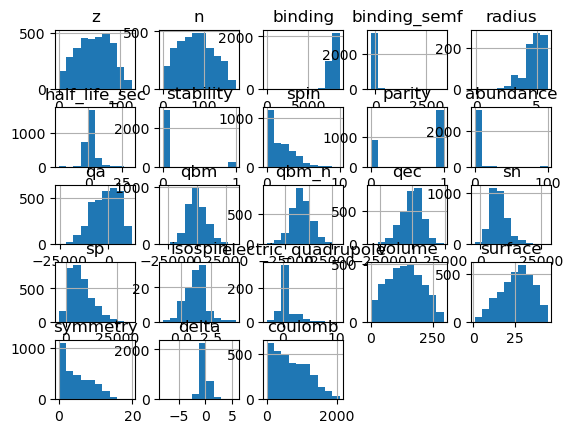

In [9]:
df.hist()

In [10]:
from kbgen.data.datasets import NuCLR
from kbgen.config import defaults_customLM as config

config["tokenizer"] = "custom"
dataset = NuCLR.from_config(config)

processed data not found, tokenizing...
done
